In [1]:
#References: https://www.youtube.com/watch?v=QIUxPv5PJOY
import numpy as np
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from pandas import read_excel

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [4]:
# load the dataset
stock_data = read_excel('ShellStockPrices.xlsx')
df = stock_data.values
stock_data.head()

,date,open,high,low,close,volume
0,2009-01-02,52.05,53.74,52.00,53.53,296100
1,2009-01-05,51.80,53.91,51.80,53.33,756000
2,2009-01-06,53.96,54.77,53.00,54.18,826200
3,2009-01-07,53.33,53.66,52.26,53.00,502800
4,2009-01-08,53.48,54.36,52.71,54.26,309400


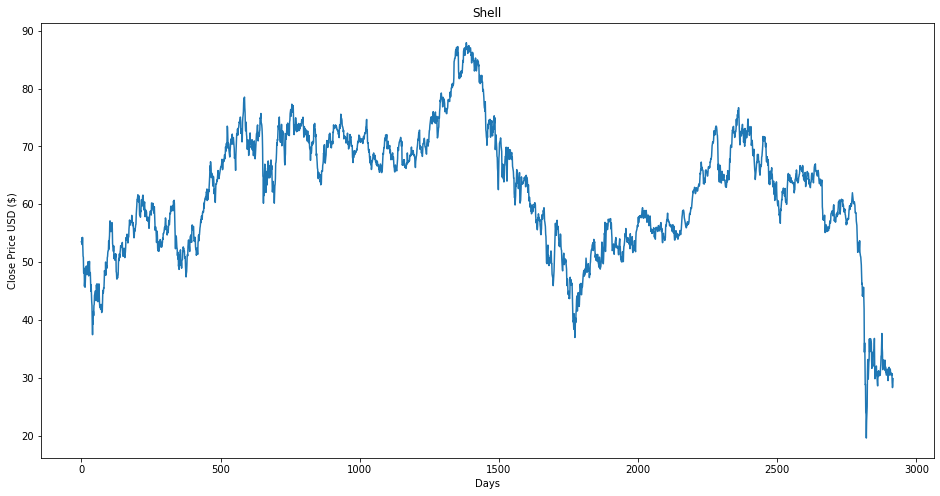

In [5]:
#Visualize the close price data
plt.figure(figsize=(16,8))
plt.title('Shell')
plt.xlabel('Days')
plt.ylabel('Close Price USD ($)')
plt.plot(stock_data['close'])
plt.show()

In [6]:
#Create a new dataset - get the close price only
stock_data = stock_data[['close']]
stock_data.head()
#convert the dataframe to a numpy array
df = stock_data.values
#get the number of rows to train the model on
training_data_len = math.ceil(len(df)*0.8)

training_data_len

2334

In [7]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df)
scaled_data

array([[0.4967808 ],
       [0.49385426],
       [0.50629207],
       ...,
       [0.12759731],
       [0.13359672],
       [0.15013169]])

In [8]:
#Create the training data set
#Creat the scaled training data set
train_data = scaled_data[0:training_data_len ,:]
#Split the data into x_train and y_train data sets
x_train =[]
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i, 0])
    if i<=61:
        print(x_train)
        print(y_train)
        print()

[array([0.4967808 , 0.49385426, 0.50629207, 0.48902546, 0.50746269,
       0.47805092, 0.46005268, 0.45697981, 0.41791045, 0.41761779,
       0.4294703 , 0.38366989, 0.39640035, 0.38147498, 0.39435177,
       0.41571554, 0.42259292, 0.43386011, 0.43503073, 0.4133743 ,
       0.41381329, 0.43034826, 0.4149839 , 0.42610477, 0.44615159,
       0.44307872, 0.41015511, 0.41893474, 0.43356746, 0.4467369 ,
       0.41542289, 0.41878841, 0.41834943, 0.39552239, 0.37152473,
       0.38732807, 0.36640328, 0.34489318, 0.33508926, 0.28767925,
       0.26134036, 0.29675154, 0.28841089, 0.32045654, 0.30962833,
       0.33508926, 0.33786948, 0.36025754, 0.36420837, 0.36830553,
       0.37211004, 0.37093942, 0.35835528, 0.34738074, 0.38747439,
       0.37225637, 0.39010828, 0.38293825, 0.37167106, 0.34489318])]
[0.35162423178226515]

[array([0.4967808 , 0.49385426, 0.50629207, 0.48902546, 0.50746269,
       0.47805092, 0.46005268, 0.45697981, 0.41791045, 0.41761779,
       0.4294703 , 0.38366989, 0.39

In [9]:
#convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [10]:
#Reshape the data
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape

(2274, 60, 1)

In [11]:
#Build LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [12]:
#Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1)

Epoch 1/1
2274/2274 [==============================] - 69s 31ms/step - loss: 0.0023


In [14]:
#Create the testing data set
#Create a new array containing scaled values
test_data = scaled_data[training_data_len - 60: ,:]
#Create the data sets x_test and y_test
x_test = []
y_test = df[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [15]:
#Convert the data to a numpy array
x_test = np.array(x_test)

In [16]:
#Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [17]:
#Get the models to predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions) #want predictions to have the same values as the y_test data set

In [18]:
#Get the root mean squared error (RSME)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

2.7871103893299662

C:\Users\Nhung Nguyen\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


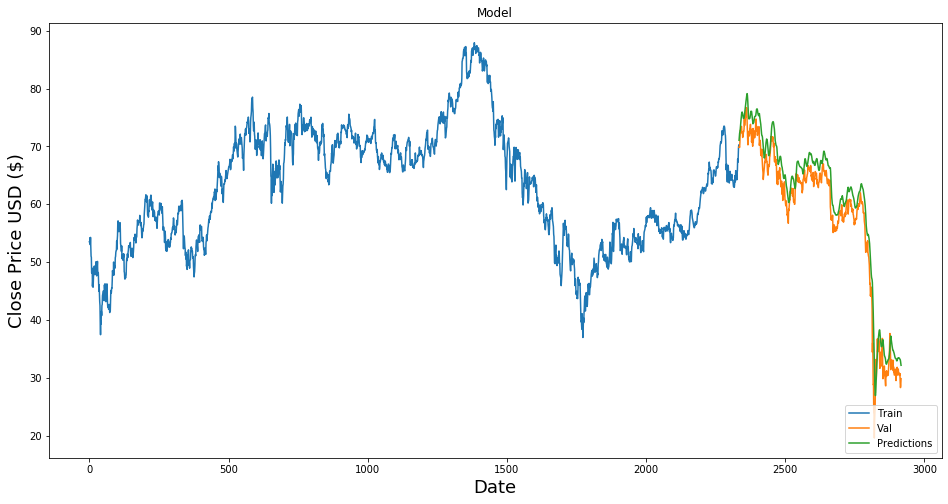

In [19]:
#Plot the data
train = stock_data[:training_data_len]
valid = stock_data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close','Predictions']])
plt.legend(['Train','Val','Predictions'],loc='lower right')
plt.show()

In [44]:
#Show the valid and predicted prices
valid

,close,Predictions
222,30.99,31.399101
223,30.22,31.184025
224,31.20,31.016289
225,30.48,30.935125
226,30.34,30.879885
227,30.94,30.838633
228,31.07,30.836903
229,30.91,30.866653
230,30.44,30.907969
231,31.58,30.932867
